In [12]:
# java version 8로 변경
!java -version
!sudo update-alternativeAs --config java
!java -version
# 그래프에서 한글표현을 위해 폰트 설치
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')
# tensorflow version을 2.x로 변경
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
# 자동 reload
%load_ext autoreload
%autoreload 2
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')


openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
sudo: update-alternativeAs: command not found
openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import io
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
#노트북에서 셀아래바로표시
%matplotlib inline 
import matplotlib.image as mpimg
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
from tensorflow.keras.applications import MobileNetV2
from scipy.spatial.distance import cosine
np.random.seed(0)
!pip3 install pickle5
import pickle5
import joblib

In [14]:
#######모델 불러오기 (dnn feature뽑아오기,als 해시태그 추천)
model_path='/content/drive/MyDrive/insta_crawling/Hashtag_Team16/modeling (1)/mobilenetv2.pkl'
neural_network = joblib.load(model_path)
spark = SparkSession.builder.master('local').appName('all').getOrCreate()
als_model = ALSModel.load('/content/drive/MyDrive/insta_crawling/Hashtag_Team16/modeling/als')

#######데이터 불러오기 (pics 이미지의 피처 데이터프레임,hashtags_df 모든해시태그, recommender_df 추천df)
pics=joblib.load('/content/drive/MyDrive/insta_crawling/Hashtag_Team16/modeling (1)/pics_0424_1.pkl')
recommender_df=joblib.load('/content/drive/MyDrive/insta_crawling/Hashtag_Team16/modeling (1)/recommender_df_0424_1.pkl')
hashtags_df=joblib.load('/content/drive/MyDrive/insta_crawling/Hashtag_Team16/modeling (1)/hashtags_df_0424_1.pkl')

In [19]:
def prepare_image(img_path, height=160, width=160):
  # 신경망에 맞게 이미지를 다운 샘플링 및 스케일링
  img = tf.io.read_file(img_path) # 불러(읽어)오기
  img = tf.image.decode_jpeg(img) # [height, width, num_channels]인 3차원 배열을 반환
  img = tf.cast(img, tf.float32) # 정수형으로 바꾼경우 소수점을 버린다 boolean일때는 True면 1, False면 0을 출력
  img = (img/127.5) - 1
  img = tf.image.resize(img, (height, width))
  # 컬러 이미지의 차원에 맞게 회색조 이미지 형태변경
  if img.shape != (160, 160, 3):
    img = tf.concat([img, img, img], axis=2)
  return img

def extract_features(image, neural_network):
  # input받은 이미지를 1280개의 deep feature들로 구성된 벡터로 반환
  image_np = image.numpy() # numpy형태로 변환
  images_np = np.expand_dims(image_np, axis=0) # 차원추가([]를 씌워준다)
  deep_features = neural_network.predict(images_np)[0]
  return deep_features

# 코사인 유사성에 기반한 K개의 최근접이웃을 찾는 함수 
# ***코사인유사도가 아닌 디텍션을 사용???
# 픽셀로 유사도 측정이면 유사도 일치가능성이 높음 (사람사진,개사진),논리적 비약이 존재
# 그렇다면 어떻게 판단할 것인가? 디텍션과 같이해서 하이브리드 모델을 만들것인가?
# 코사인유사도 뽑고 디텍션,세그멘테이션 이미지도 뽑아서 둘 중 높은 것을 순서대로 출력?(weight를 어떻게 주느냐에 따라 달라질것이니)
# 댓글 필터링 어떤식으로 할것인가?
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    # 비슷한 이미지에 대한 img_features(이미지 피쳐, 즉 사용자 벡터)를 찾는다.
    prep_image = prepare_image(image_path)
    pics = extract_features(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, pics))
    rdf = rdf.sort_values(by='dist')
    return rdf.head(k)
  

def generate_hashtags(image_path):
    fnv = find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df)
    # 코사인 유사성에 기반하여 5개의 사용자 벡터의 평균을 구한다.
    features = []
    for item in fnv.features.values:
        features.append(item)

    avg_features = np.mean(np.asarray(features), axis=0)
    
    hashtag_features = als_model.itemFactors.toPandas()

    # 앞서 구한 이미지(사용자) 피쳐의 평균, 즉 avg_features을 hashtag_features와 dot product하여 새로운 dot_product열 생성
    hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))
    
    # 가장 높은 dot product를 가진 해시태그 상위 10개 추출
    final_recs = hashtag_features.sort_values(by='dot_product', ascending=False).head(50)

    # hastag_id로 hashtag 찾아서 output에 저장
    output = []
    for hashtag_id in final_recs.id.values:
        output.append(hashtags_df.iloc[hashtag_id]['hashtag'])
    return output

# test할 이미지데이터에 대한 해시태그 분석
def show_results(test_image):
    img = mpimg.imread(f'/content/drive/My Drive/HASHTAIG/result/{test_image}.jpg')
    plt.figure(figsize=(9, 9)) 
    plt.imshow(img)
    
    recommended_hashtags = generate_hashtags(f'/content/drive/My Drive/HASHTAIG/result/{test_image}.jpg')
    # print(', '.join(recommended_hashtags))
    return recommended_hashtags

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


['#멍스타그램',
 '#강아지',
 '#댕댕이',
 '#반려견',
 '#dog',
 '#dogstagram',
 '#개스타그램',
 '#멍멍이',
 '#펫스타그램',
 '#puppy',
 '#멍팔',
 '#견스타그램',
 '#pet',
 '#반려동물',
 '#독스타그램',
 '#petstagram',
 '#강아지스타그램',
 '#강아지그램',
 '#인스타독',
 '#댕댕이그램',
 '#댕스타그램',
 '#포메라니안',
 '#댕팔',
 '#말티즈',
 '#instadog',
 '#산책',
 '#애견',
 '#인스타펫',
 '#개',
 '#푸들',
 '#포메',
 '#멍팔환영',
 '#멍멍이그램',
 '#pomeranian',
 '#강아지모델',
 '#🐶',
 '#반려견그램',
 '#오늘의강아지',
 '#비숑',
 '#멍멍스타그램',
 '#개린이',
 '#멍뭉이',
 '#cute',
 '#애견인',
 '#강아지옷',
 '#믹스견',
 '#dogsofinstagram',
 '#말티푸',
 '#doglife',
 '#애견스타그램']

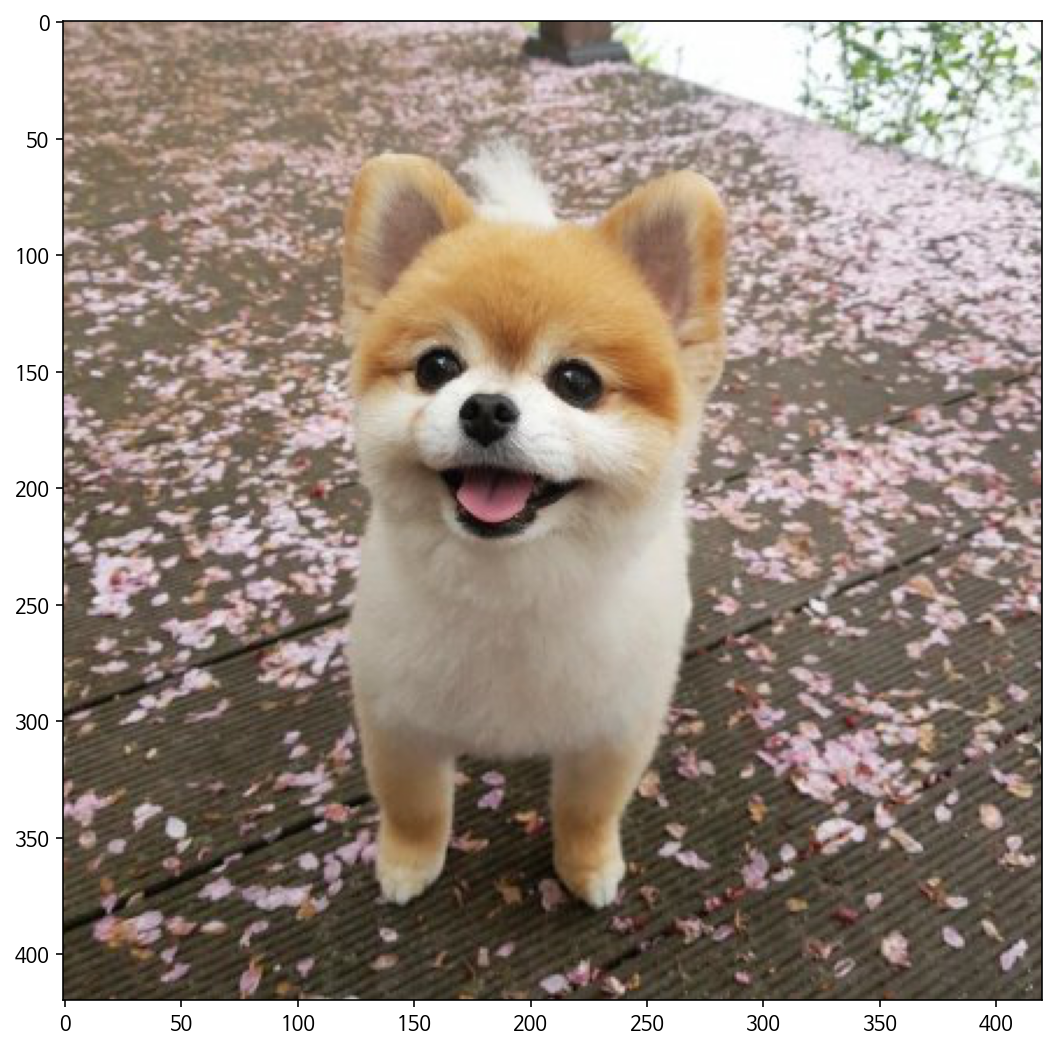

In [20]:
show_results('img')